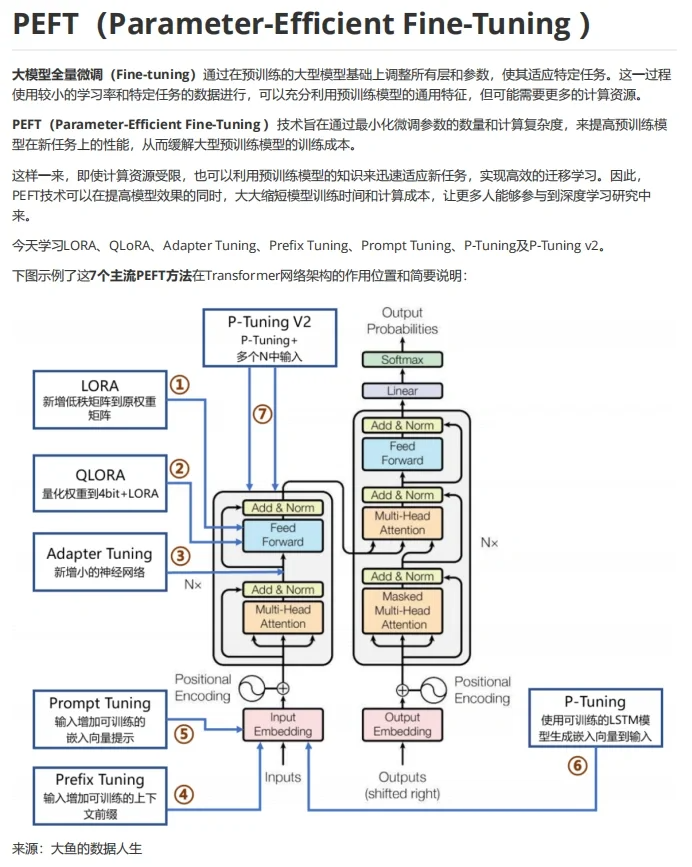

# LORA
LoRA 通过将大模型中的部分权重矩阵（如注意力层的 Wq、Wv）分解为两个低秩矩阵 A、B，只训练这两个小矩阵，其余参数保持冻结。这样可以用极少的参数实现模型微调。

过程
选择需要微调的线性层（如 Attention 层）。
将原始权重 W 替换为 $W + \Delta W$，其中 $\Delta W = BA$，A、B 是低秩矩阵（秩远小于原始矩阵）。
训练时只更新 A、B，W 保持不变。
推理时可将 LoRA 融合进原模型或单独存储。

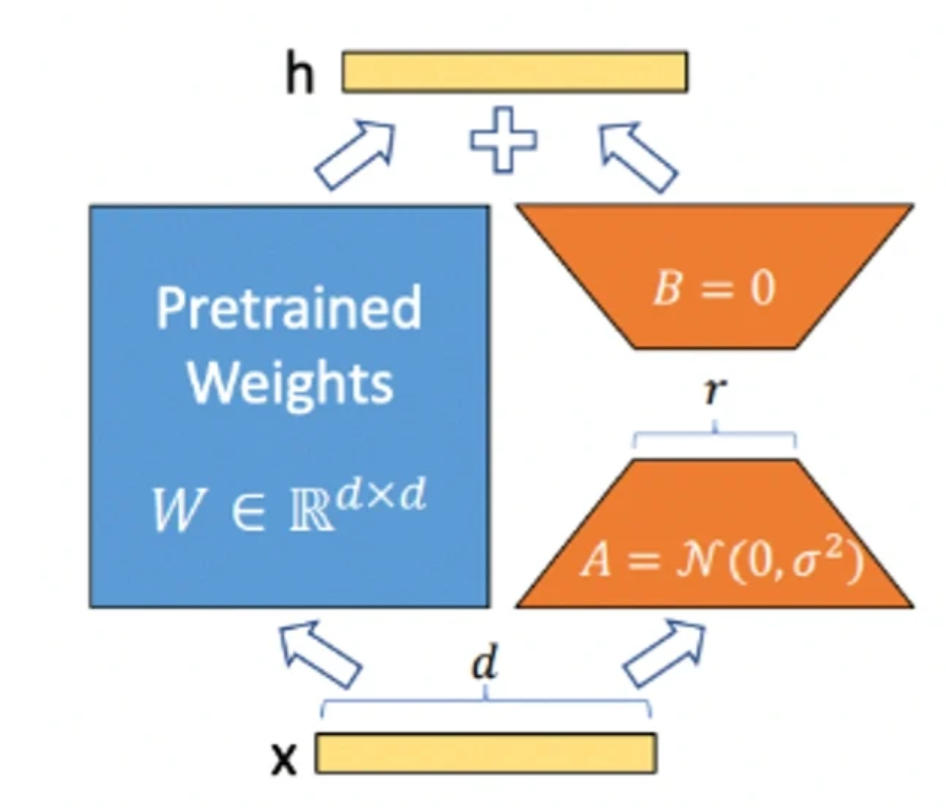

# QLORA
QLoRA(Quantized Low-Rank Adaptation)是一种高效的模型微调方法，它在LoRA(Low-RankAdaptation)的基础上引入了深度量化过程。QLORA的核心特点包括:
+ 量化技术:QLORA使用一种新颖的高精度技术将预训练模型量化为4-bit。这种技术包括一种低精度存储数据类型(4-bit NormalFloat，简写为NF4)和一种计算数据类型(16-bit BrainHoat)。这样做可以在保持整个模型精度损失极小的同时，减少存储需求。
+ 双重量化:将量化常数进行量化的方法，平均每个参数节省约0.37位(对于65B模型约3GB)Paged Optimizers:使用NVIDIA统一内存来避免在处理长席列的小批次时出现梯度变量的内存峰值,
微调过程:
+ 在训练过程中，QLORA首先将模型用4-bit加载，然后在训练时把数值反量化到bf16后进行训练。这样的设计使得训练所需的显存大大减少。例如，一个33B的LLaMA模型可以在24 GB的显卡上进行训练。由于量化显著减少了模型的精确度，这通常会带来性能上的损失。然而，对于大型模型，这种方法可以大幅减少内存和计算需求，使得在资源有限的环境下部署和训练成为可能。
+ 量化过程中的关键挑战是如何设计映射和量化策略，以尽量减少因精度损失带来的性能下降。

# adapter tuning
Adapter Tuning 在 Transformer 每一层插入小型 Adapter 模块（通常是瓶颈结构的两层 MLP），只训练 Adapter，主模型参数冻结。Adapter 通过残差连接影响主模型输出。

过程
在每层 Transformer 后插入 Adapter（如 Down-Projection → 非线性 → Up-Projection）。
训练时只更新 Adapter 参数。
推理时 Adapter 与主模型一起工作。

# prefix tuning
Prefix Tuning 为每层注意力机制引入可训练的“前缀向量”，这些向量作为虚拟 token 参与注意力计算，主模型参数冻结。

过程
为每层注意力机制添加一组可学习的前缀向量（如长度为 k）。
训练时只更新前缀向量。
推理时将前缀向量拼接到输入 token 前，参与注意力。

# prompt tuning
Prompt Tuning是一种微调方法，它在预训练语言模型的输入中添加可学习的嵌入向量作为提示。这些提示被设计成在训练过程中更新，以引导模型输出对特定任务更有用的响应。
Prompt Tuning和Prefix Tuning都涉及在输入数据中加入可学习的向量，这些元素是在输入层添加的，但两者的策略和目的是不一样的:
Prompt Tuning:可学习向量(通常称为prompt tokens)旨在模仿自然语言提示的形式，它们被设计为引导模型针对特定任务生成特定类型的输出。这些向量通常被看作是任务指导信息的一部分，倾向于用更少量的向量模仿传统的自然语言提示。
Prefix Tuning:可学习前缀则更多地用于提供输入数据的直接上下文信息，这些前缀作为模型内部表示的一部分，可以影响整个模型的行为。
下面的训练例子说明了两者的区别:
Prompt Tuning示例:
输入序列:[Prompt1][Prompt2]"这部电影令人振奋。
问题: 评价这部电影的情感倾向。
答案: 模型需要预测情感倾向(例如“积极”)
提示:无明确的外部提示，[Prompt1][Prompt2]充当引导模型的内部提示，因为这里的问题是隐含的，即判断文本中表达的情感倾向。
Prefix Tuning 示例:
输入序列: [Prefix1] [Prefix2] [Prefix3]"l want to watch a movie."
问题: 根据前缀生成后续的自然语言文本。
答案: 模型生成的文本，如“that is exciting and fun."
提示: 前缀本身提供上下文信息，没有单独的外部提示

# p-tuning
P.Tuning(Prompt-based Tuning)和Prompt Tuning都是调整大型预训练语言模型(如GPT系列)以适应特定任务的技术。
两者都旨在利用预训练的语言模型来执行特定的下游任务，如文本分类、情感分析等。它们都使用某种形式的“提示“或”指导“来引导模型的输出，以更好地适应特定任务。
Prompt Tuning与P-Tuning的区别主要在于:
Prompt Tuning:使用静态的、可训练的虚拟标记嵌入。这些嵌入在初始化后保持固定，除非在训练过程中被更新，相对简单，因为它只涉及调整一组固定的嵌入参数。在处理多种任务时表现良好，但可能在处理特别复杂或需要细粒度控制的任务时受限。
P.Tuning:使用一个可训练的LSTM模型(称为prompt encoder)来动态生成虚拟标记嵌入，允许根据输入数据的不同生成不同的嵌入，提供了更高的灵活性和适应性，适合需要精细控制和理解复杂上下文的任务，相对复杂，因为它涉及一个额外的LSTM模型来生成虚拟标记嵌入。
在P-Tuning中使用LSTM(长短期记忆网络)作为生成虚拟标记嵌入的工具，充分利用了LSTM的优势，包括更好的适应性和灵活性:由于LSTM可以捕捉输入数据中的时间序列特征，它能够更好地理解和适应复杂的、顺序依赖的任务，如文本生成或序列标注。
改进的上下文理解:LSTM由于其循环结构，擅长处理和理解长期依赖关系和复杂的上下文信息。
参数共享和泛化能力:在P-Tuning中，LSTM模型的参数可以在多个任务之间共享，这可以提高模型的泛化能力，并减少针对每个单独任务的训练需求。而在Prompt Tuning中，每个任务通常都有其独立的虚拟标记嵌入，这可能限制了跨任务泛化的能力。

P-Tuning v2 将软 prompt 应用于模型所有层（深度插入），不仅仅是输入层，并支持大规模预训练模型。

过程
在每一层 Transformer 插入可学习的 prompt 向量。
训练时更新所有层的 prompt 参数。
推理时所有层都拼接 prompt 向量。